In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [4]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/bdt/notebooks/")

from bdt import *
from models import *

In [5]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets

# set the inputs
reco_versions = ["evtgen_v4_rec_v9"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [6]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [7]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/bdt/notebooks/test_model_zheyang/plots"
os.system(f"mkdir -p {plotting_path}")

0

In [8]:
# weight functions
spline_file = '/data/ana/Diffuse/NNMFit/MCEq_splines/v1.2.1/MCEq_splines_PRI-Gaisser-H4a_INT-SIBYLL23c_allfluxes.pickle'

# conventional            
flux_keys_conv =  ['conv_antinumu','conv_numu','conv_antinue','conv_nue','conv_antinutau','conv_nutau']
spline_object_conv = SplineHandler(spline_file, flux_keys_conv)
conv_flux = spline_object_conv.return_weight
generator_conv = lambda pdgid, energy, cos_zen: conv_flux(pdgid, energy, cos_zen)

# prompt
flux_keys_pr =  ['pr_antinumu','pr_numu','pr_antinue','pr_nue','pr_antinutau','pr_nutau']
spline_object_pr = SplineHandler(spline_file, flux_keys_pr)
pr_flux = spline_object_pr.return_weight
generator_pr = lambda pdgid, energy, cos_zen: pr_flux(pdgid, energy, cos_zen)

# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [9]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    # calculate weights
    for key in simulation_dataset:
        simulation_dataset[key]['weights_astro'] = simulation_dataset[key]["weighter"].get_weights(AstroFluxModel) * livetime_s
        simulation_dataset[key]['weights_conv'] = simulation_dataset[key]["weighter"].get_weights(generator_conv) * livetime_s
        simulation_dataset[key]['weights_pr'] = simulation_dataset[key]["weighter"].get_weights(generator_pr) * livetime_s


    return simulation_dataset



In [10]:
keys_to_merge = {}

keys_to_merge["evtgen_v4_rec_v9"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}


In [11]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau


In [12]:
dataset_label_dict = {
    "evtgen_v4_rec_v9" : "ftp-v3",
    "spice_tau_reco" : "spice v3.2.1",
}

check if merging works now, seems to be fine

In [13]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    ConventionalAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("ConventionalAtmosphericPassingFractions", "value")
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s * ConventionalAtmosphericPassingFractions
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    PromptAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("PromptAtmosphericPassingFractions", "value")
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s * PromptAtmosphericPassingFractions
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

           astro_NuE    astro_NuMu   astro_NuTau            conv       prompt
ftp-v3  56.92 ± 0.55  20.60 ± 0.25  35.03 ± 0.40  25.684 ± 0.991  7.07 ± 0.09


In [14]:
# load bdt models
import joblib

loaded_models = {
    name: {
        "model1": joblib.load(info["model1"]),
        "model2": joblib.load(info["model2"])
    }
    for name, info in models.items()
}

/data/user/tvaneede/software/py_venvs/py3-v4.4.1_reco-v1.1.0/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/cvmfs/icecube.opensciencegrid.org/py3-v4.4.1/RHEL_7_x86_64_v2/lib/python3.12/pickle.py:1753: UserWarning: [13:33:46] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling


In [15]:
def append_bdt_scores(simulation_dataset, model_pair):
    for flavor in ["NuE", "NuMu", "NuTau", "NuAll"]:
        weighter = simulation_dataset[flavor]["weighter"]
        bdt1, bdt2 = Append_BDT(weighter, model_pair["model1"], model_pair["model2"])
        # Attach as new columns
        simulation_dataset[flavor]["bdt_scores1"] = bdt1
        simulation_dataset[flavor]["bdt_scores2"] = bdt2

In [23]:
# plot bdt score
# simulation_dataset_name = "evtgen_v2_rec_v5"
colors = ["C0","C3","C2"]

def plot_bdt_score( simulation_dataset,
                    model_name,
                    cut_bdt1,
                    cut_bdt2,
                    energy_cut_threshold=None,
                    savename = "test" ):

    model_pair = loaded_models[model_name]
    append_bdt_scores(simulation_dataset, model_pair)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

    bins = np.linspace(0,1,20)

    for i,flavor in enumerate(["NuE","NuMu", "NuTau"]):

        RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s

        classification_variables = {
            "bdt_scores1" : simulation_dataset[flavor]["bdt_scores1"],
            "bdt_scores2" : simulation_dataset[flavor]["bdt_scores2"]
        }

        if energy_cut_threshold:
            mask = RecoETot > energy_cut_threshold
        else:
            mask = np.ones_like(RecoETot, dtype=bool)
            
        # bdt score 1
        ax1.hist(classification_variables["bdt_scores1"][mask], weights=weights[mask], 
                 bins=bins, histtype="step", color=colors[i], linestyle="-",label = flavor)

        mask &= classification_variables["bdt_scores1"] > cut_bdt1

        # Upper plot: histograms
        ax2.hist(classification_variables["bdt_scores2"][mask], weights=weights[mask], 
                 bins=bins, histtype="step", color=colors[i], linestyle="-",label = flavor)

    fig.suptitle(rf"Model name: {model_name}, cut_bdt1: {cut_bdt1:.2f}, cut_bdt2: {cut_bdt2:.2f}", fontsize=16)

    ax1.set_yscale('log')
    ax1.set_ylabel(f'Rate / {livetime_yr:.2f} yr')
    ax1.set_xlabel('BDT score 1')
    ax1.legend()
    ax1.grid(True)
    ax1.axvline(x = cut_bdt1,color='black', linestyle='--', linewidth=2)

    ax2.set_yscale('log')
    ax2.set_ylabel(f'Rate / {livetime_yr:.2f} yr')
    ax2.set_xlabel('BDT score 2')
    ax2.legend()
    ax2.grid(True)
    ax2.axvline(x = cut_bdt2,color='black', linestyle='--', linewidth=2)
    plt.savefig(f"{plotting_path}/{savename}_{model_name}_bdt1-{cut_bdt1:.3f}_bdt1-{cut_bdt2:.3f}_energy-{energy_cut_threshold}.pdf")



In [17]:
classifications = {}

classifications["FinalTopology"] = {
    "variables" : ["FinalTopology"],
    "cut_functions" : {
        "Cascade" : lambda vars: vars["FinalTopology"] == 1,            
        "Double"  : lambda vars: vars["FinalTopology"] == 2,           
        "Track"   : lambda vars: vars["FinalTopology"] == 3,
    }
}

classifications["bdt_zheyang_best"] = {
    "variables" : ["bdt_scores1", "bdt_scores2"],
    "cut_functions" : {
        "Cascade" : lambda vars:  vars["bdt_scores1"] < 0.28,            
        "Double"  : lambda vars: (vars["bdt_scores1"] > 0.28) & (vars["bdt_scores2"] > 0.59),      
        "Track"   : lambda vars: (vars["bdt_scores1"] > 0.28) & (vars["bdt_scores2"] < 0.59),
    }
}

def create_bdt_classification( cut_bdt1, cut_bdt2 ):

    return {
    "variables" : ["bdt_scores1", "bdt_scores2"],
        "cut_functions" : {
            "Cascade" : lambda vars:  vars["bdt_scores1"] < cut_bdt1,            
            "Double"  : lambda vars: (vars["bdt_scores1"] > cut_bdt1) & (vars["bdt_scores2"] > cut_bdt2),      
            "Track"   : lambda vars: (vars["bdt_scores1"] > cut_bdt1) & (vars["bdt_scores2"] < cut_bdt2),
        }
    }

In [18]:
def analyze_classification_rates_with_cut(
    simulation_dataset, 
    classification, 
    model_name=None,
    energy_cut_threshold=None,
    print_output=True,
):
    # Assumes the following are defined globally:
    # - AstroFluxModel
    # - generator_conv
    # - generator_pr
    # - livetime_s

    # append bdt scores
    if model_name:
        model_pair = loaded_models[model_name]
        append_bdt_scores(simulation_dataset, model_pair)

    def get_total_rates():
        total = {}
        for flavor in ['NuE', 'NuMu', 'NuTau']:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
            if energy_cut_threshold:
                RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")
                mask = RecoETot > energy_cut_threshold
                weights = weights[mask]
            total[flavor] = np.sum(weights)
        return total

    total_rates = get_total_rates()

    data = {}
    purity = {}
    efficiency = {}

    for ch in classification["cut_functions"]:
        channel_data = {}
        rates = {"total": 0}

        # Conventional + Prompt (NuAll)
        flavor_all = "NuAll"
        ConventionalAtmosphericPassingFractions = simulation_dataset[flavor_all]["weighter"].get_column("ConventionalAtmosphericPassingFractions", "value")
        PromptAtmosphericPassingFractions = simulation_dataset[flavor_all]["weighter"].get_column("PromptAtmosphericPassingFractions", "value")            
        RecoETot = simulation_dataset[flavor_all]["weighter"].get_column("RecoETot", "value")

        # Load required variables for this classification
        if "bdt_scores1" in classification["variables"]:
            classification_variables = {
                "bdt_scores1" : simulation_dataset[flavor_all]["bdt_scores1"],
                "bdt_scores2" : simulation_dataset[flavor_all]["bdt_scores2"]
            }
        else:
            classification_variables = {
                var: simulation_dataset[flavor_all]["weighter"].get_column(var, "value")
                for var in classification["variables"]
            }

        # Apply the cut function, passing the variables dict
        mask = classification["cut_functions"][ch](classification_variables)

        if energy_cut_threshold:
            mask &= RecoETot > energy_cut_threshold

        weights_conv = simulation_dataset[flavor_all]["weighter"].get_weights(generator_conv) * livetime_s * ConventionalAtmosphericPassingFractions
        rate_conv = np.sum(weights_conv[mask])
        err_conv = np.sqrt(np.sum(weights_conv[mask]**2))
        channel_data["Conventional"] = f"{rate_conv:.2f} ± {err_conv:.2f}"
        rates["total"] += rate_conv

        weights_prompt = simulation_dataset[flavor_all]["weighter"].get_weights(generator_pr) * livetime_s * PromptAtmosphericPassingFractions
        rate_prompt = np.sum(weights_prompt[mask])
        err_prompt = np.sqrt(np.sum(weights_prompt[mask]**2))
        channel_data["Prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"
        rates["total"] += rate_prompt

        # Astro components
        for flavor in ['NuE', 'NuMu', 'NuTau']:
            RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")

            # Load required variables for this classification
            if "bdt_scores1" in classification["variables"]:
                classification_variables = {
                    "bdt_scores1" : simulation_dataset[flavor]["bdt_scores1"],
                    "bdt_scores2" : simulation_dataset[flavor]["bdt_scores2"]
                }
            else:
                classification_variables = {
                    var: simulation_dataset[flavor]["weighter"].get_column(var, "value")
                    for var in classification["variables"]
                }

            # Apply the cut function, passing the variables dict
            mask = classification["cut_functions"][ch](classification_variables)

            if energy_cut_threshold:
                mask &= RecoETot > energy_cut_threshold

            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
            rate = np.sum(weights[mask])
            err = np.sqrt(np.sum(weights[mask]**2))
            channel_data[f"Astro {flavor}"] = f"{rate:.2f} ± {err:.2f}"
            rates[flavor] = rate
            rates["total"] += rate

        data[ch] = channel_data

        # Purity and Efficiency
        purity[ch] = {
            f: f"{rates[f]/rates['total']:.2f}" for f in ['NuE', 'NuMu', 'NuTau']
        }
        efficiency[ch] = {
            f: f"{rates[f]/total_rates[f]:.2f}" for f in ['NuE', 'NuMu', 'NuTau']
        }

    # Build DataFrames
    df = pd.DataFrame.from_dict(data, orient='index')
    column_order = [f"Astro {f}" for f in ['NuE', 'NuMu', 'NuTau']] + ["Conventional", "Prompt"]
    df = df[column_order]

    purity_df = pd.DataFrame(purity).T.round(4)
    purity_df.columns = ['NuE', 'NuMu', 'NuTau']
    purity_df.index.name = "Class"

    efficiency_df = pd.DataFrame(efficiency).T.round(4)
    efficiency_df.columns = ['NuE', 'NuMu', 'NuTau']
    efficiency_df.index.name = "Class"

    if print_output:
        print("\n=== Rates ===\n")
        print(df.to_string())
        print("\n=== Purity ===\n")
        print(purity_df)
        print("\n=== Efficiency ===\n")
        print(efficiency_df)
        print("\n=== Rates ===\n")
        print(df.to_latex(column_format="l" + "c" * len(df.columns), escape=False))
        print("\n=== Purity ===\n")
        print(purity_df.to_latex(column_format="lccc", escape=False))
        print("\n=== Efficiency ===\n")
        print(efficiency_df.to_latex(column_format="lccc", escape=False))

    return df, purity_df, efficiency_df

Testing if my new cutting function works, yes it does!

In [19]:
# test my benchmark
analyze_classification_rates_with_cut(simulation_datasets["evtgen_v4_rec_v9"], classification=classifications["FinalTopology"], model_name=None,energy_cut_threshold=60e3)
# analyze_classification_rates_with_cut(simulation_datasets["evtgen_v4_rec_v9"], classification=classifications["FinalTopology"], model_name=None,energy_cut_threshold=None)
# works like a charm!


=== Rates ===

            Astro NuE   Astro NuMu   Astro NuTau Conventional       Prompt
Cascade  39.75 ± 0.41  6.03 ± 0.11  19.26 ± 0.25  5.04 ± 0.25  3.71 ± 0.06
Double    0.29 ± 0.03  0.42 ± 0.03   3.99 ± 0.10  0.43 ± 0.09  0.13 ± 0.01
Track     0.29 ± 0.03  8.27 ± 0.13   1.04 ± 0.05  4.29 ± 0.24  0.54 ± 0.02

=== Purity ===

          NuE  NuMu NuTau
Class                    
Cascade  0.54  0.08  0.26
Double   0.05  0.08  0.76
Track    0.02  0.57  0.07

=== Efficiency ===

          NuE  NuMu NuTau
Class                    
Cascade  0.99  0.41  0.79
Double   0.01  0.03  0.16
Track    0.01  0.56  0.04

=== Rates ===

\begin{tabular}{lccccc}
\toprule
 & Astro NuE & Astro NuMu & Astro NuTau & Conventional & Prompt \\
\midrule
Cascade & 39.75 ± 0.41 & 6.03 ± 0.11 & 19.26 ± 0.25 & 5.04 ± 0.25 & 3.71 ± 0.06 \\
Double & 0.29 ± 0.03 & 0.42 ± 0.03 & 3.99 ± 0.10 & 0.43 ± 0.09 & 0.13 ± 0.01 \\
Track & 0.29 ± 0.03 & 8.27 ± 0.13 & 1.04 ± 0.05 & 4.29 ± 0.24 & 0.54 ± 0.02 \\
\bottomrule
\end{ta

(            Astro NuE   Astro NuMu   Astro NuTau Conventional       Prompt
 Cascade  39.75 ± 0.41  6.03 ± 0.11  19.26 ± 0.25  5.04 ± 0.25  3.71 ± 0.06
 Double    0.29 ± 0.03  0.42 ± 0.03   3.99 ± 0.10  0.43 ± 0.09  0.13 ± 0.01
 Track     0.29 ± 0.03  8.27 ± 0.13   1.04 ± 0.05  4.29 ± 0.24  0.54 ± 0.02,
           NuE  NuMu NuTau
 Class                    
 Cascade  0.54  0.08  0.26
 Double   0.05  0.08  0.76
 Track    0.02  0.57  0.07,
           NuE  NuMu NuTau
 Class                    
 Cascade  0.99  0.41  0.79
 Double   0.01  0.03  0.16
 Track    0.01  0.56  0.04)

Now, lets first apply zheyangs model and my retrained model, using the best bdt parameters found. Important, they were optimised for a spectrum with gamma = 2.5 and for the cascade sample, not the hese sample.

Conclusion. They are very similar, but lead to a very impure double cascade sample. Without any atmospheric neutrinos, but with many nue and numu.


=== Rates ===

            Astro NuE    Astro NuMu   Astro NuTau  Conventional       Prompt
Cascade  51.63 ± 0.53   7.18 ± 0.17  23.53 ± 0.36  15.45 ± 0.83  5.76 ± 0.08
Double    4.92 ± 0.13   1.38 ± 0.04  10.05 ± 0.16   0.50 ± 0.09  0.46 ± 0.02
Track     0.37 ± 0.06  12.04 ± 0.17   1.45 ± 0.07   9.74 ± 0.53  0.86 ± 0.03

=== Purity ===

          NuE  NuMu NuTau
Class                    
Cascade  0.50  0.07  0.23
Double   0.28  0.08  0.58
Track    0.02  0.49  0.06

=== Efficiency ===

          NuE  NuMu NuTau
Class                    
Cascade  0.91  0.35  0.67
Double   0.09  0.07  0.29
Track    0.01  0.58  0.04

=== Rates ===

\begin{tabular}{lccccc}
\toprule
 & Astro NuE & Astro NuMu & Astro NuTau & Conventional & Prompt \\
\midrule
Cascade & 51.63 ± 0.53 & 7.18 ± 0.17 & 23.53 ± 0.36 & 15.45 ± 0.83 & 5.76 ± 0.08 \\
Double & 4.92 ± 0.13 & 1.38 ± 0.04 & 10.05 ± 0.16 & 0.50 ± 0.09 & 0.46 ± 0.02 \\
Track & 0.37 ± 0.06 & 12.04 ± 0.17 & 1.45 ± 0.07 & 9.74 ± 0.53 & 0.86 ± 0.03 \\
\bottomr

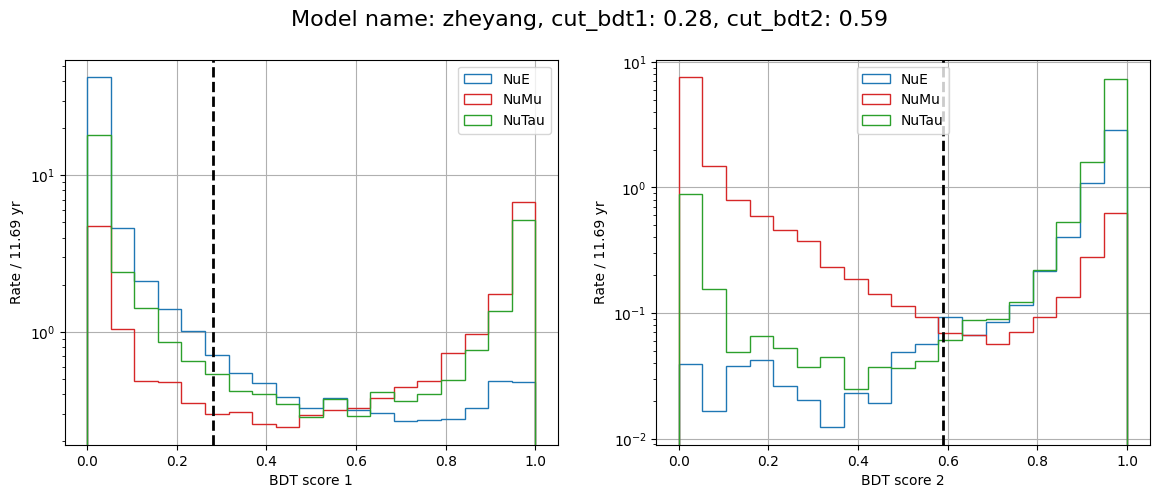

In [24]:
analyze_classification_rates_with_cut(simulation_datasets["evtgen_v4_rec_v9"], classifications["bdt_zheyang_best"], model_name="zheyang",energy_cut_threshold=None)
plot_bdt_score( simulation_datasets["evtgen_v4_rec_v9"], 
                model_name="zheyang", 
                cut_bdt1=0.28, 
                cut_bdt2=0.59, 
                energy_cut_threshold=None,
                savename="evtgen_v4_rec_v9" )


=== Rates ===

            Astro NuE    Astro NuMu   Astro NuTau  Conventional       Prompt
Cascade  51.50 ± 0.53   6.88 ± 0.17  23.36 ± 0.36  15.18 ± 0.83  5.73 ± 0.08
Double    5.06 ± 0.13   1.43 ± 0.05  10.13 ± 0.16   0.52 ± 0.09  0.47 ± 0.02
Track     0.36 ± 0.05  12.30 ± 0.18   1.54 ± 0.07   9.99 ± 0.53  0.87 ± 0.03

=== Purity ===

          NuE  NuMu NuTau
Class                    
Cascade  0.50  0.07  0.23
Double   0.29  0.08  0.58
Track    0.01  0.49  0.06

=== Efficiency ===

          NuE  NuMu NuTau
Class                    
Cascade  0.90  0.33  0.67
Double   0.09  0.07  0.29
Track    0.01  0.60  0.04

=== Rates ===

\begin{tabular}{lccccc}
\toprule
 & Astro NuE & Astro NuMu & Astro NuTau & Conventional & Prompt \\
\midrule
Cascade & 51.50 ± 0.53 & 6.88 ± 0.17 & 23.36 ± 0.36 & 15.18 ± 0.83 & 5.73 ± 0.08 \\
Double & 5.06 ± 0.13 & 1.43 ± 0.05 & 10.13 ± 0.16 & 0.52 ± 0.09 & 0.47 ± 0.02 \\
Track & 0.36 ± 0.05 & 12.30 ± 0.18 & 1.54 ± 0.07 & 9.99 ± 0.53 & 0.87 ± 0.03 \\
\bottomr

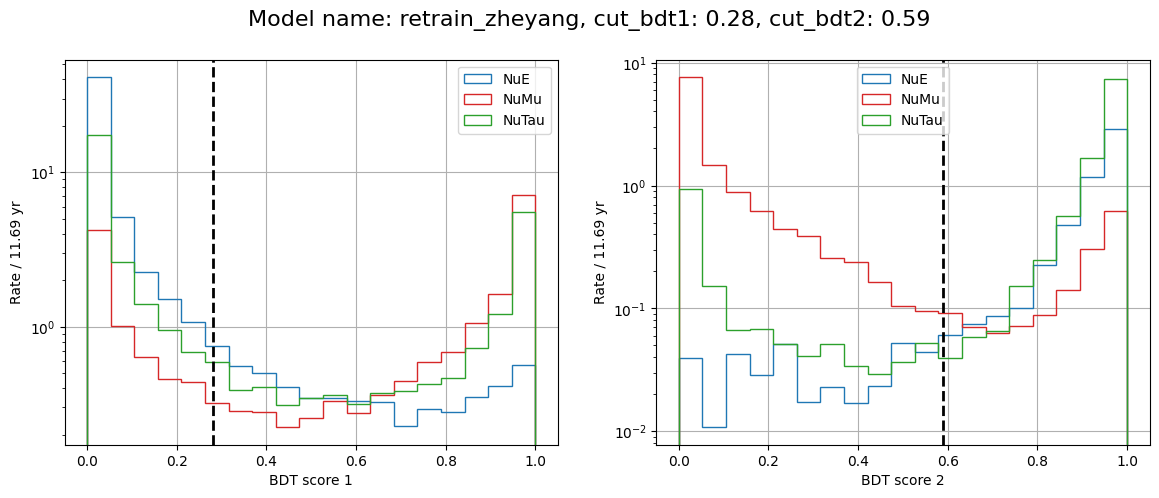

In [26]:
analyze_classification_rates_with_cut(simulation_datasets["evtgen_v4_rec_v9"], classifications["bdt_zheyang_best"], model_name="retrain_zheyang",energy_cut_threshold=None)
plot_bdt_score( simulation_datasets["evtgen_v4_rec_v9"], 
                model_name="retrain_zheyang", 
                cut_bdt1=0.28, cut_bdt2=0.59, 
                energy_cut_threshold=None,
                savename="evtgen_v4_rec_v9" )

I just randomly check a bdt score cut myself, seems to work pretty well


=== Rates ===

            Astro NuE    Astro NuMu   Astro NuTau  Conventional       Prompt
Cascade  55.36 ± 0.54  10.29 ± 0.20  27.15 ± 0.37  19.44 ± 0.92  6.27 ± 0.09
Double    1.44 ± 0.07   0.60 ± 0.03   6.87 ± 0.13   0.16 ± 0.03  0.22 ± 0.01
Track     0.12 ± 0.02   9.71 ± 0.14   1.00 ± 0.05   6.09 ± 0.37  0.58 ± 0.02

=== Purity ===

          NuE  NuMu NuTau
Class                    
Cascade  0.47  0.09  0.23
Double   0.16  0.06  0.74
Track    0.01  0.55  0.06

=== Efficiency ===

          NuE  NuMu NuTau
Class                    
Cascade  0.97  0.50  0.78
Double   0.03  0.03  0.20
Track    0.00  0.47  0.03

=== Rates ===

\begin{tabular}{lccccc}
\toprule
 & Astro NuE & Astro NuMu & Astro NuTau & Conventional & Prompt \\
\midrule
Cascade & 55.36 ± 0.54 & 10.29 ± 0.20 & 27.15 ± 0.37 & 19.44 ± 0.92 & 6.27 ± 0.09 \\
Double & 1.44 ± 0.07 & 0.60 ± 0.03 & 6.87 ± 0.13 & 0.16 ± 0.03 & 0.22 ± 0.01 \\
Track & 0.12 ± 0.02 & 9.71 ± 0.14 & 1.00 ± 0.05 & 6.09 ± 0.37 & 0.58 ± 0.02 \\
\bottomru

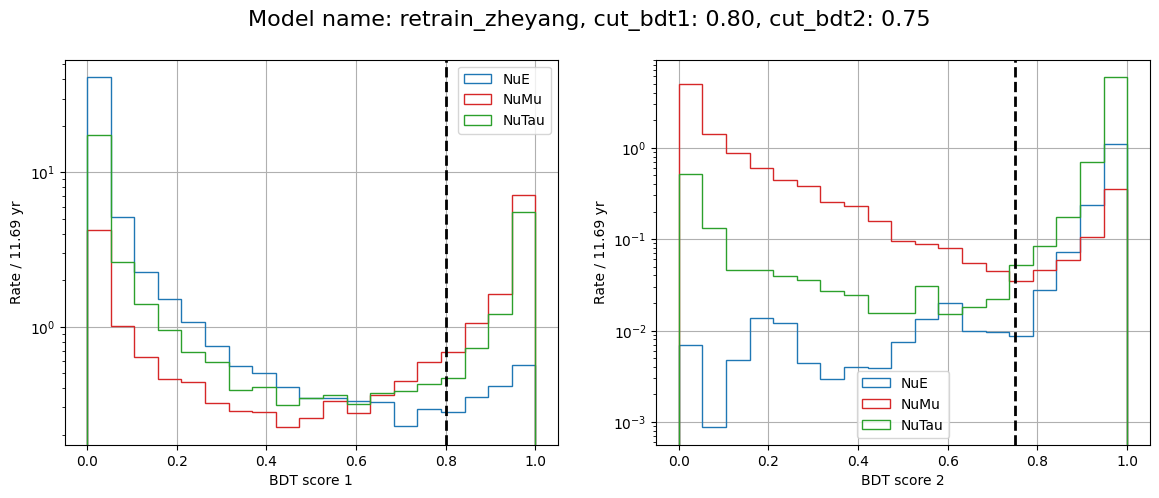

In [25]:
classification = create_bdt_classification( cut_bdt1=0.80, cut_bdt2=0.75 )
analyze_classification_rates_with_cut(simulation_datasets["evtgen_v4_rec_v9"], classification=classification, model_name="retrain_zheyang",energy_cut_threshold=None)
plot_bdt_score( simulation_datasets["evtgen_v4_rec_v9"], 
                model_name="retrain_zheyang", 
                cut_bdt1=0.80, cut_bdt2=0.75, 
                energy_cut_threshold=None,
                savename="evtgen_v4_rec_v9" )

Lets do this in a proper way, just like zheyang does it.

In [21]:
from tqdm import tqdm

n = 50
bdt_cuts = np.linspace(0.01,1,n)
model_name = "retrain_zheyang"
energy_cut_threshold = None
simulation_dataset = simulation_datasets["evtgen_v4_rec_v9"]

# Define the cases we want to track
cases = [
    ("Cascade", "NuE"),
    ("Track", "NuMu"),
    ("Double", "NuTau"),
]

# Collect results in a list of dicts
results_list = []

for cut_bdt1 in tqdm(bdt_cuts, desc="BDT1 loop"):
# for cut_bdt1 in bdt_cuts:
    for cut_bdt2 in bdt_cuts:
        classification = create_bdt_classification( cut_bdt1=cut_bdt1, cut_bdt2=cut_bdt2 )
        df, purity_df, efficiency_df = analyze_classification_rates_with_cut(simulation_dataset=simulation_dataset, 
                                                                             classification=classification, 
                                                                             model_name=model_name,
                                                                             energy_cut_threshold=energy_cut_threshold,
                                                                             print_output=False)

        # Extract purity for each case and append to results DataFrame
        for event_class, flavor in cases:
            purity     = purity_df.loc[event_class, flavor]
            efficiency = efficiency_df.loc[event_class, flavor]
            results_list.append({
                "cut_bdt1": cut_bdt1,
                "cut_bdt2": cut_bdt2,
                "Class": event_class,
                "Flavor": flavor,
                "Purity": float(purity),
                "Efficiency": float(efficiency),
            })
        
results = pd.DataFrame(results_list)

BDT1 loop:   0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_62856/1762648068.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f: f"{rates[f]/rates['total']:.2f}" for f in ['NuE', 'NuMu', 'NuTau']
BDT1 loop:   2%|▏         | 1/50 [00:33<26:59, 33.05s/it]/tmp/ipykernel_62856/1762648068.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f: f"{rates[f]/rates['total']:.2f}" for f in ['NuE', 'NuMu', 'NuTau']
BDT1 loop:   4%|▍         | 2/50 [01:06<26:27, 33.07s/it]/tmp/ipykernel_62856/1762648068.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f: f"{rates[f]/rates['total']:.2f}" for f in ['NuE', 'NuMu', 'NuTau']
BDT1 loop:   6%|▌         | 3/50 [01:39<25:54, 33.08s/it]/tmp/ipykernel_62856/1762648068.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f: f"{rates[f]/rates['total']:.2f}" for f in ['NuE', 'NuMu', 'NuTau']
BDT1 loop:   8%|▊         | 4/50 [02:12<25:20, 33.04s/it]/tmp/ipykernel_62856/1762648068.py:109: RuntimeWarning: invalid value encountered in sca

---------- purity 0.71 efficiency 0.22
cut_bdt1 0.676734693877551 cut_bdt2 0.7171428571428571

=== Rates ===

            Astro NuE    Astro NuMu   Astro NuTau  Conventional       Prompt
Cascade  54.75 ± 0.54   9.08 ± 0.19  26.21 ± 0.37  17.89 ± 0.89  6.12 ± 0.09
Double    2.03 ± 0.08   0.74 ± 0.03   7.69 ± 0.14   0.18 ± 0.04  0.26 ± 0.01
Track     0.14 ± 0.02  10.78 ± 0.16   1.13 ± 0.05   7.61 ± 0.44  0.69 ± 0.02

=== Purity ===

          NuE  NuMu NuTau
Class                    
Cascade  0.48  0.08  0.23
Double   0.19  0.07  0.71
Track    0.01  0.53  0.06

=== Efficiency ===

          NuE  NuMu NuTau
Class                    
Cascade  0.96  0.44  0.75
Double   0.04  0.04  0.22
Track    0.00  0.52  0.03

=== Rates ===

\begin{tabular}{lccccc}
\toprule
 & Astro NuE & Astro NuMu & Astro NuTau & Conventional & Prompt \\
\midrule
Cascade & 54.75 ± 0.54 & 9.08 ± 0.19 & 26.21 ± 0.37 & 17.89 ± 0.89 & 6.12 ± 0.09 \\
Double & 2.03 ± 0.08 & 0.74 ± 0.03 & 7.69 ± 0.14 & 0.18 ± 0.04 & 0.26 ± 0.0

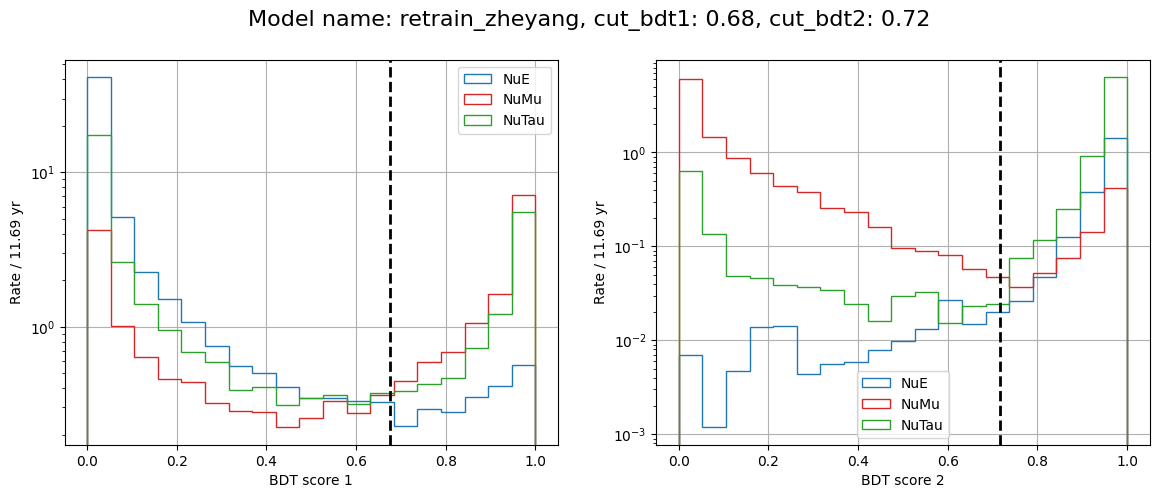

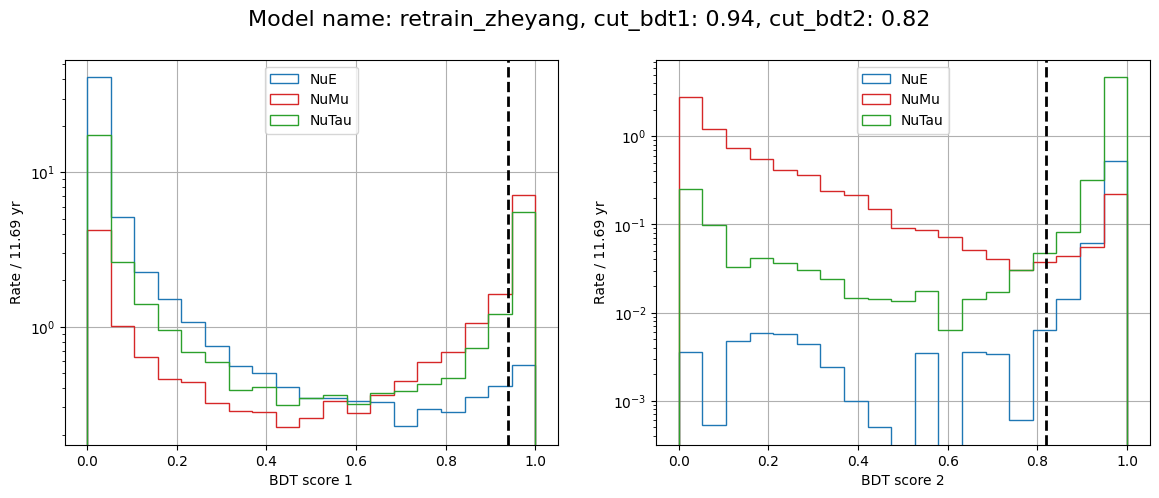

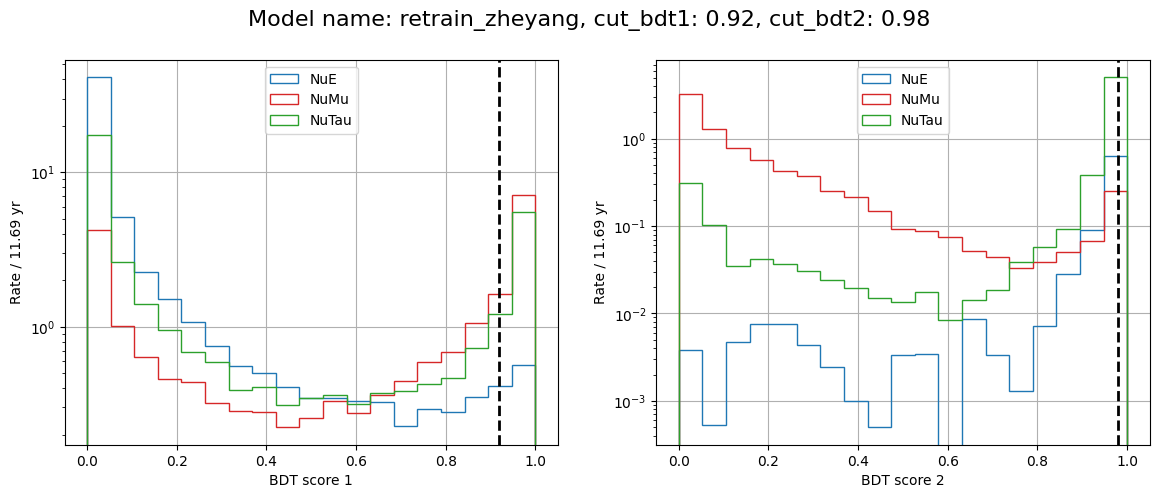

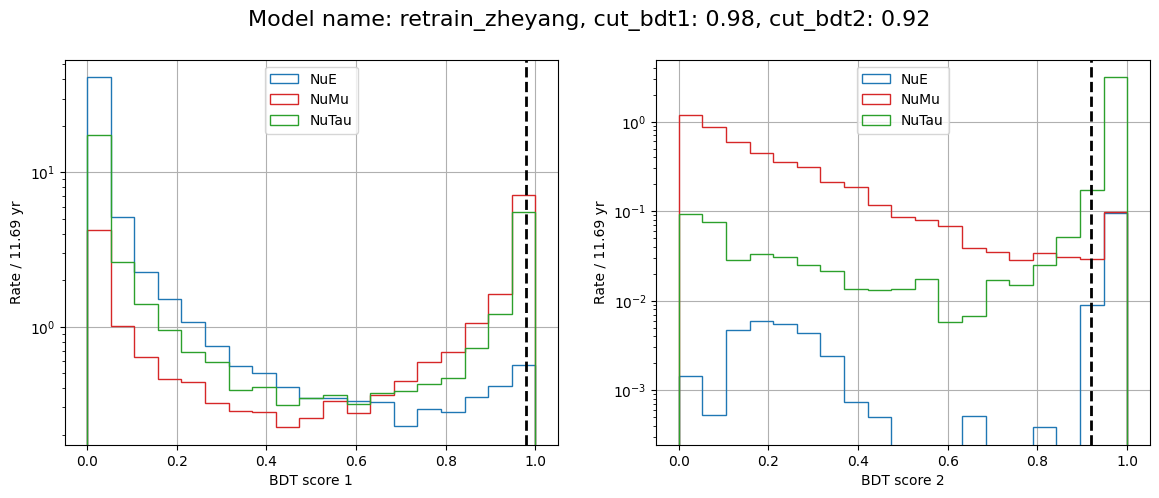

In [28]:
class_opt = "Double"
flavor_opt = "NuTau"

for minimum_purity in [0.7,0.80,0.85,0.90]:
    results_opt = results[ (results["Class"] == class_opt) & (results["Flavor"] == flavor_opt) & (results["Purity"] > minimum_purity) ].sort_values(by="Efficiency", ascending=False).reset_index(drop=True).iloc[0]

    print(10*"-", "purity",results_opt["Purity"], "efficiency",results_opt["Efficiency"])
    print("cut_bdt1",results_opt["cut_bdt1"], "cut_bdt2",results_opt["cut_bdt2"])

    classification = create_bdt_classification( cut_bdt1=results_opt["cut_bdt1"], 
                                                cut_bdt2=results_opt["cut_bdt2"] )
    
    analyze_classification_rates_with_cut(simulation_dataset, 
                                          classification=classification, 
                                          model_name=model_name,
                                          energy_cut_threshold=None)
    plot_bdt_score( simulation_dataset, 
                    model_name=model_name,
                    cut_bdt1=results_opt["cut_bdt1"], 
                    cut_bdt2=results_opt["cut_bdt2"], 
                    energy_cut_threshold=energy_cut_threshold,
                    savename="optimised" )